In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

## Helpers

In [136]:
## Function to plot correlation matrix in a heatmap for a group of column starting with a prefix
def plot_correlation_heatmap(df, prefix, with_target=False):
    cols = [col for col in df.columns if col.startswith(prefix)]
    if with_target:
        cols.append("target")
    corr = df[cols].corr()
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr, annot=True, fmt=".2f")
    plt.show()

## Function to sum all a group of columns starting with a prefix
def sum_columns(df, prefix):
    cols = [col for col in df.columns if col.startswith(prefix)]
    return df[cols].sum(axis=1)

## Function to make cross-validation given the model and data and number of splits
def cross_val(model, X, y, n_splits=5):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    kf = KFold(n_splits=n_splits, shuffle=False)
    rmse = []
    r2 = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse.append(np.sqrt(mean_squared_error(y_test, preds)))
        r2.append(r2_score(y_test, preds))
    return np.mean(rmse), np.mean(r2), rmse, r2

## Data Cleaning

### Overview

In [4]:
df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
vocab_df = pd.read_csv('variable_descriptions.csv')
df.head()

ward  total_households  total_individuals     target     dw_00  \
0  41601001: Ward 1        1674.45058         5888.20750  16.773757  0.933841   
1  41601002: Ward 2        1736.99230         6735.33812  21.496661  0.696940   
2  41601003: Ward 3        2403.57591         7273.04995  10.931425  0.810545   
3  41601004: Ward 4        1740.78737         5734.49046  23.119257  0.659914   
4  41601005: Ward 5        1730.51451         6657.23835  13.652252  0.950575   

      dw_01     dw_02     dw_03     dw_04     dw_05  ...     pw_03     pw_04  \
0  0.000846  0.005490  0.000676  0.000000  0.001372  ...  0.002848  0.007537   
1  0.001253  0.004402  0.000000  0.002301  0.001323  ...  0.014566  0.057127   
2  0.004517  0.008891  0.003986  0.007735  0.000956  ...  0.057560  0.010358   
3  0.000000  0.006129  0.000000  0.000813  0.037245  ...  0.000000  0.000669   
4  0.000655  0.001473  0.000598  0.006999  0.000818  ...  0.004859  0.001290   

      pw_05     pw_06  pw_07  pw_08  ADM4_PCODE        lat        lon  \
0  0.000000  0.012928      0      0   ZA4161001 -29.682270  24.734743   
1  0.019092  0.004131      0      0   ZA4161002 -29.119311  24.757737   
2  0.001421  0.040881      0      0   ZA4161003 -29.142276  25.094093   
3  0.000000  0.005011      0      0   ZA4161004 -29.372052  24.942867   
4  0.000673  0.017629      0      0   ZA4161005 -29.409381  25.290165   

         NL  
0  0.292039  
1  3.207775  
2  0.000000  
3  2.038778  
4  0.000000  

[5 rows x 63 columns]

In [6]:
## Check for missing values
df.isnull().sum()

ward                 0
total_households     0
total_individuals    0
target               0
dw_00                0
                    ..
pw_08                0
ADM4_PCODE           0
lat                  0
lon                  0
NL                   0
Length: 63, dtype: int64

In [7]:
## Check for duplicates
df.duplicated().sum()

np.int64(0)

In [8]:
## Check for duplicates in columns
df.columns.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

total_households  total_individuals       target        dw_00  \
count       2822.000000        2822.000000  2822.000000  2822.000000   
mean        3665.281214       12869.130053    24.507554     0.712196   
std         3266.364522        9696.690518    10.294387     0.214035   
min            1.000000         402.000000     0.000000     0.000000   
25%         1778.858235        7071.205695    16.751556     0.594212   
50%         2398.249935        9366.989680    24.156670     0.766841   
75%         3987.080563       14241.233015    32.226553     0.881708   
max        39684.942130       91716.746370    55.528423     0.994962   

             dw_01        dw_02        dw_03        dw_04        dw_05  \
count  2822.000000  2822.000000  2822.000000  2822.000000  2822.000000   
mean      0.092616     0.032043     0.006057     0.008665     0.006289   
std       0.182852     0.080253     0.019374     0.030697     0.024606   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.002895     0.002407     0.000000     0.000000     0.000000   
50%       0.010425     0.005762     0.000807     0.000607     0.000865   
75%       0.068209     0.027913     0.002538     0.002225     0.003027   
max       0.931490     0.951806     0.264239     0.392085     0.435912   

             dw_06  ...        pw_02        pw_03        pw_04        pw_05  \
count  2822.000000  ...  2822.000000  2822.000000  2822.000000  2822.000000   
mean      0.022375  ...     0.127555     0.041589     0.019655     0.011008   
std       0.037127  ...     0.156400     0.057331     0.032926     0.023672   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.002716  ...     0.008673     0.002099     0.000715     0.000159   
50%       0.008639  ...     0.069065     0.016496     0.005164     0.001459   
75%       0.025218  ...     0.183384     0.058626     0.025055     0.009432   
max       0.412936  ...     1.000000     0.327393     0.306787     0.228261   

             pw_06   pw_07   pw_08          lat          lon           NL  
count  2822.000000  2822.0  2822.0  2822.000000  2822.000000  2822.000000  
mean      0.110818     0.0     0.0   -26.880740    28.666515    17.437560  
std       0.185401     0.0     0.0     2.021279     2.373809    18.958621  
min       0.000000     0.0     0.0   -32.490089    16.760022     0.000000  
25%       0.005217     0.0     0.0   -28.569019    27.707932     3.033397  
50%       0.025165     0.0     0.0   -26.549866    28.959679     9.205572  
75%       0.116638     0.0     0.0   -25.572130    30.441505    26.890531  
max       0.961523     0.0     0.0   -22.331267    32.858249    63.000000  

[8 rows x 61 columns]

In [10]:
df.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'psa_00', 'psa_01',
       'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01',
       'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
       'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
       'lan_12', 'lan_13', 'lan_14', 'pg_00', 'pg_01', 'pg_02', 'pg_03',
       'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05',
       'pw_06', 'pw_07', 'pw_08', 'ADM4_PCODE', 'lat', 'lon', 'NL'],
      dtype='object')

In [13]:
df["ADM4_PCODE"].nunique(), df["ADM4_PCODE"].shape[0]

(2822, 2822)

We have the same number of ADM4_PCODE and ward. This means that each ADM4_PCODE is a unique ward.

In [42]:
col_prefix = ["psa", "stv", "car", "lln", "lan", "dw", "pg", "pw"]
for col in col_prefix:
    print("Min: ", sum_columns(df, col).value_counts().index.min(), "Max: ", sum_columns(df, col).value_counts().index.max(), "Column: ", col)

Min:  0.9999999528999999 Max:  1.0000000497 Column:  psa
Min:  1.0 Max:  1.0 Column:  stv
Min:  1.0 Max:  1.0000000001 Column:  car
Min:  1.0 Max:  1.0 Column:  lln
Min:  0.9999999155000001 Max:  1.0000001177 Column:  lan
Min:  0.9999999507 Max:  1.0000000286000001 Column:  dw
Min:  0.9999999502 Max:  1.0000000713 Column:  pg
Min:  0.9999999636000001 Max:  1.0000000499 Column:  pw


In [43]:
col_prefix = ["psa", "stv", "car", "lln", "lan", "dw", "pg", "pw"]
for col in col_prefix:
    print("Min: ", sum_columns(data, col).value_counts().index.min(), "Max: ", sum_columns(data, col).value_counts().index.max(), "Column: ", col)

Min:  0.9999999528999999 Max:  1.0000000497 Column:  psa
Min:  1.0 Max:  1.0 Column:  stv
Min:  1.0 Max:  1.0000000001 Column:  car
Min:  1.0 Max:  1.0 Column:  lln
Min:  0.9999999155000001 Max:  1.0000001177 Column:  lan
Min:  0.9999999507 Max:  1.0000000286000001 Column:  dw
Min:  0.9999999502 Max:  1.0000000713 Column:  pg
Min:  0.9999999636000001 Max:  1.0000000499 Column:  pw


### Dwelling columns

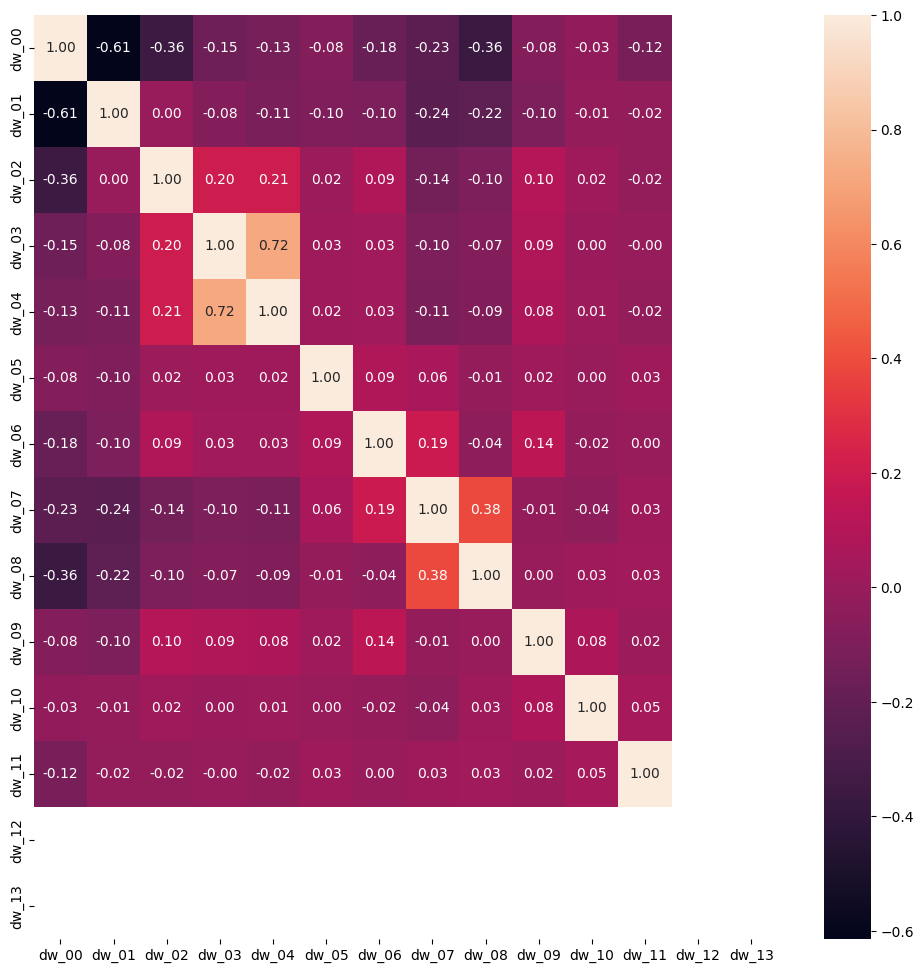

In [16]:
plot_correlation_heatmap(df, "dw")

In [17]:
df["dw_12"].value_counts()

dw_12
0    2822
Name: count, dtype: int64

In [18]:
df["dw_13"].value_counts()

dw_13
0    2822
Name: count, dtype: int64

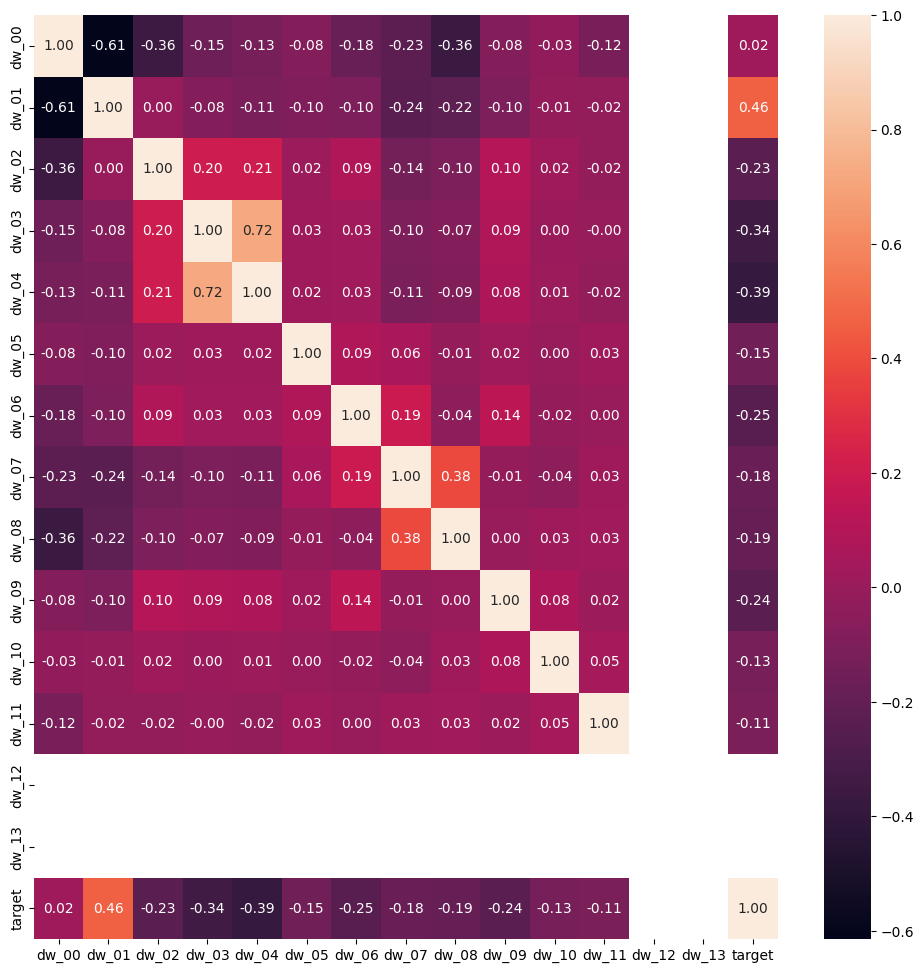

In [21]:
plot_correlation_heatmap(df, "dw", with_target=True)

In [22]:
## Copy the data
data = df.copy()

## Drop the columns
data.drop([ "dw_12", "dw_13"], axis=1, inplace=True)

In [166]:
dropped_cols = ["dw_12", "dw_13"]

We drop the columns `dw_12` and `dw_13` because they are null columns. They have only one unique value.

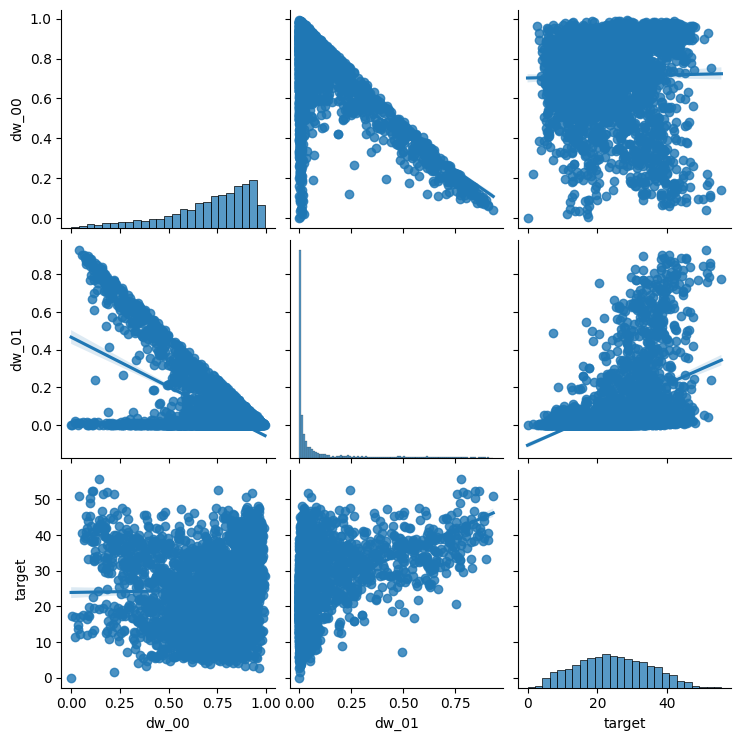

In [23]:
## Plot scatter plot for the columns with the target, and regression line
sns.pairplot(data[["dw_00", "dw_01", "target"]], kind="reg")

### Attendance columns

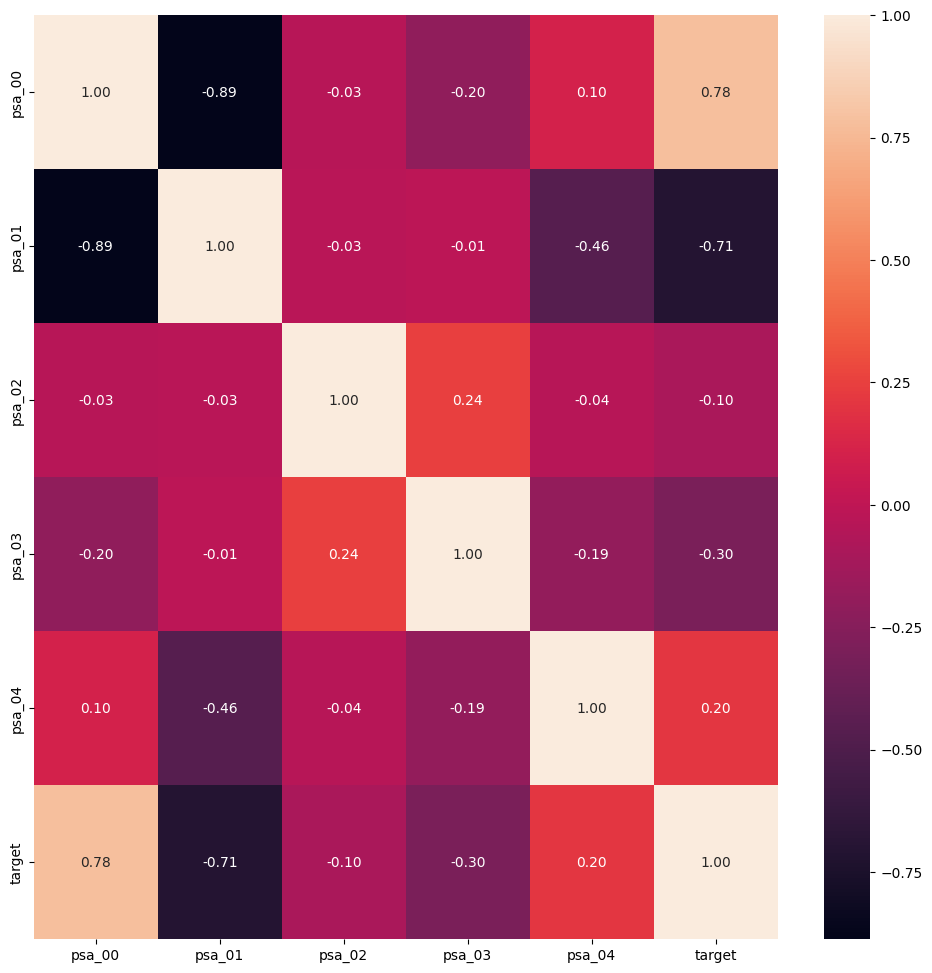

In [24]:
plot_correlation_heatmap(df, "psa", with_target=True)

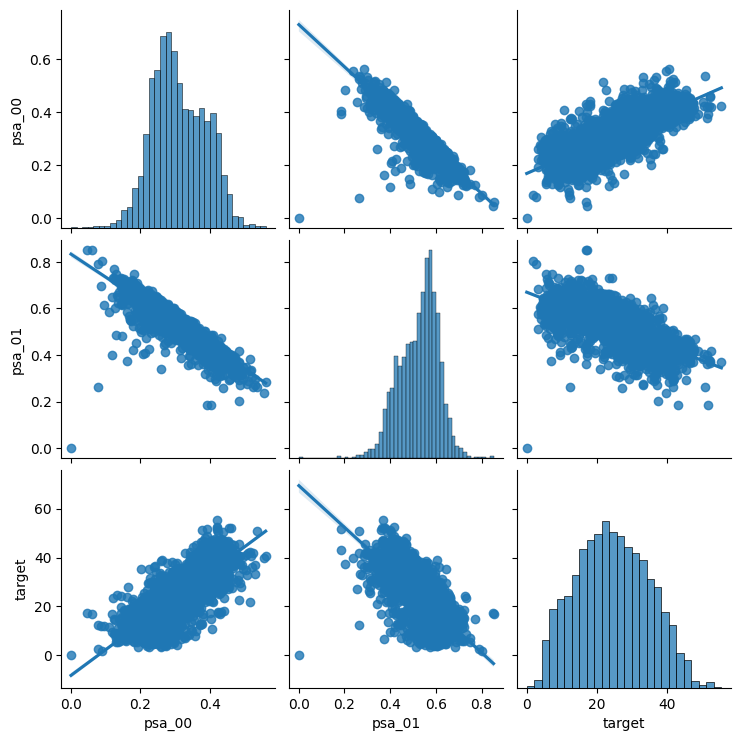

In [25]:
sns.pairplot(data[["psa_00", "psa_01", "target"]], kind="reg")


In [49]:
## Check outliers
df[(df["psa_00"] < 0.2) & (df["psa_01"] < 0.4)]

ward  total_households  total_individuals     target  \
25     41801006: Ward 6         720.17486         5222.35932  12.334957   
190    42001003: Ward 3        1885.08285         8387.02626   6.793013   
1815  93601011: Ward 11           1.00000         3867.00000   0.000000   

         dw_00     dw_01     dw_02     dw_03     dw_04     dw_05  ...  \
25    0.818426  0.010663  0.056551  0.000000  0.003236  0.019736  ...   
190   0.828974  0.004949  0.104238  0.001202  0.013877  0.011399  ...   
1815  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  ...   

         pw_03     pw_04     pw_05     pw_06  pw_07  pw_08  ADM4_PCODE  \
25    0.020023  0.005564  0.001664  0.016103      0      0   ZA4181006   
190   0.002588  0.000000  0.000530  0.002413      0      0   ZA4201003   
1815  0.000000  0.000000  0.000000  0.000000      0      0   ZA9361011   

            lat        lon         NL  
25   -28.390050  26.879394   0.000000  
190  -27.629787  27.228124  20.972154  
1815 -24.852036  27.349494  11.015128  

[3 rows x 63 columns]

### Language columns

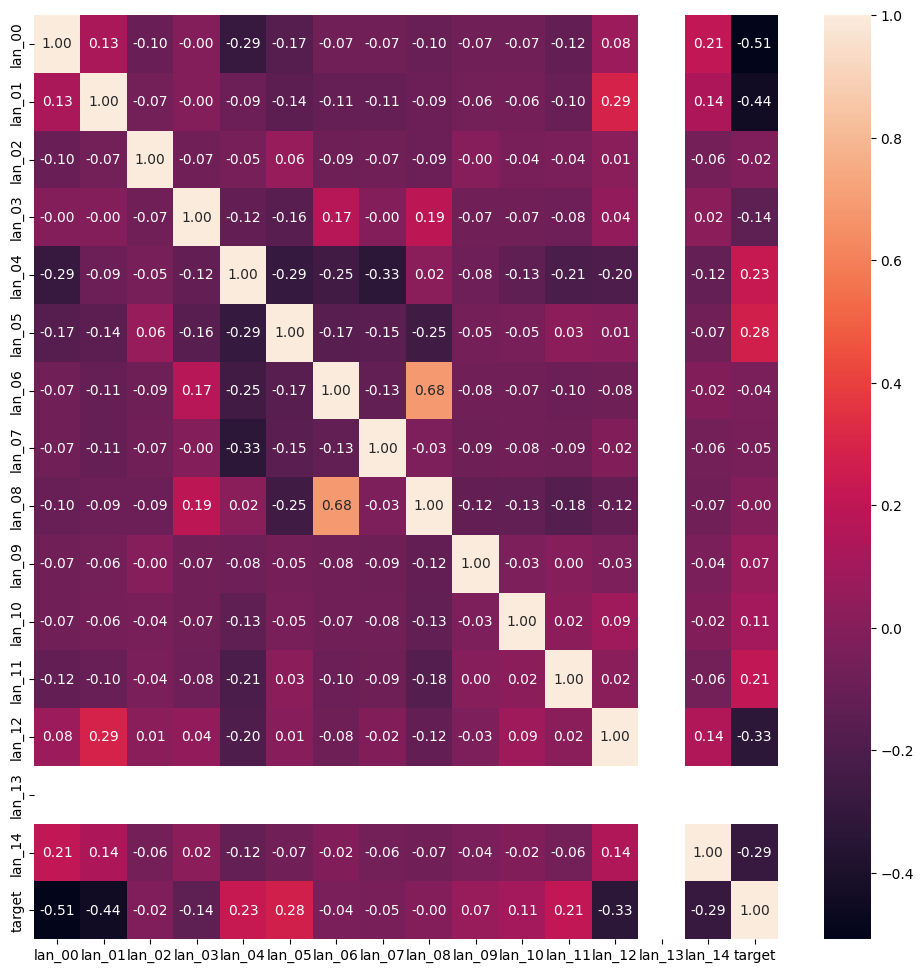

In [50]:
plot_correlation_heatmap(df, "lan", with_target=True)

In [51]:
data.drop(["lan_13"], axis=1, inplace=True)

In [167]:
dropped_cols = dropped_cols + ["lan_13"]

### Population group columns

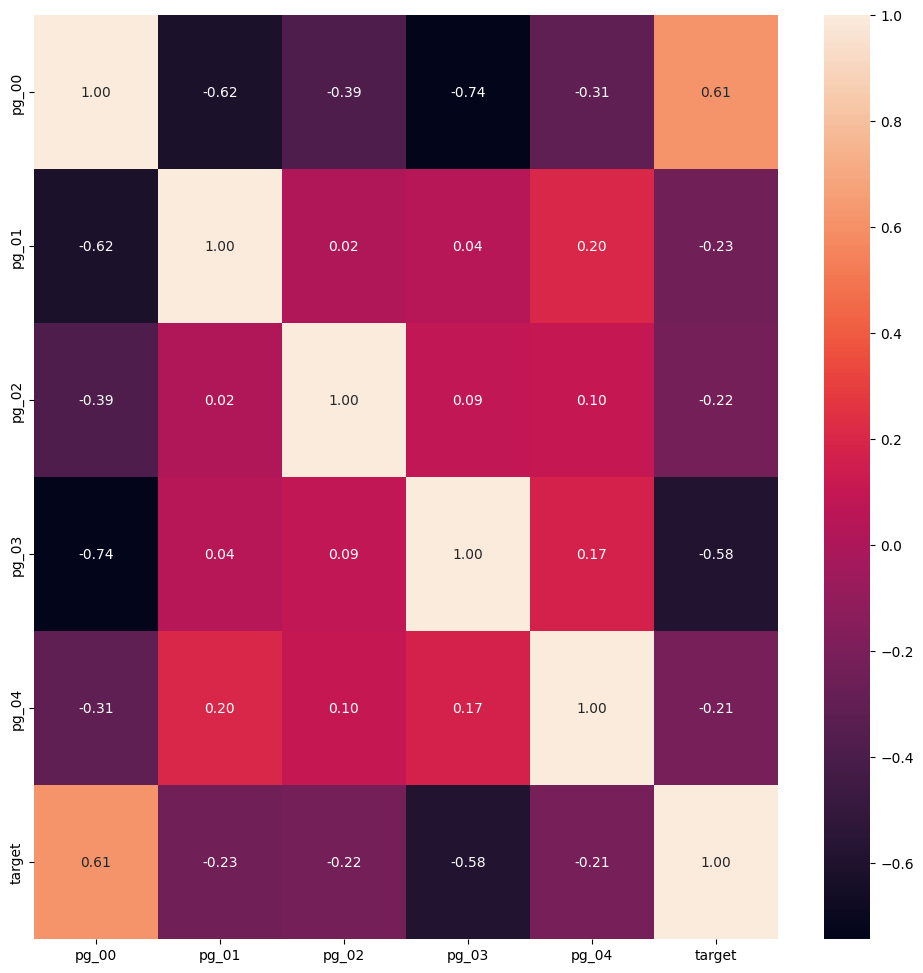

In [52]:
plot_correlation_heatmap(df, "pg", with_target=True)

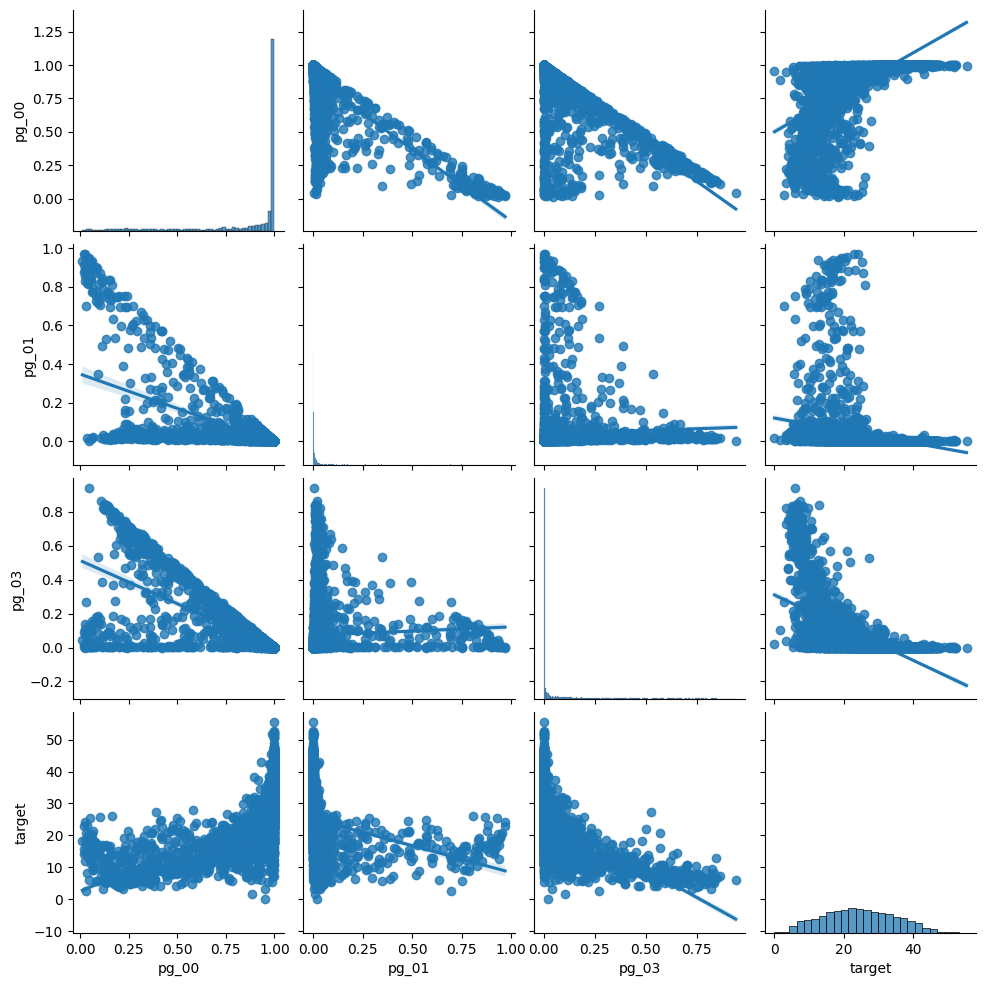

In [53]:
sns.pairplot(data[["pg_00", "pg_01", "pg_03", "target"]], kind="reg")

### Water columns

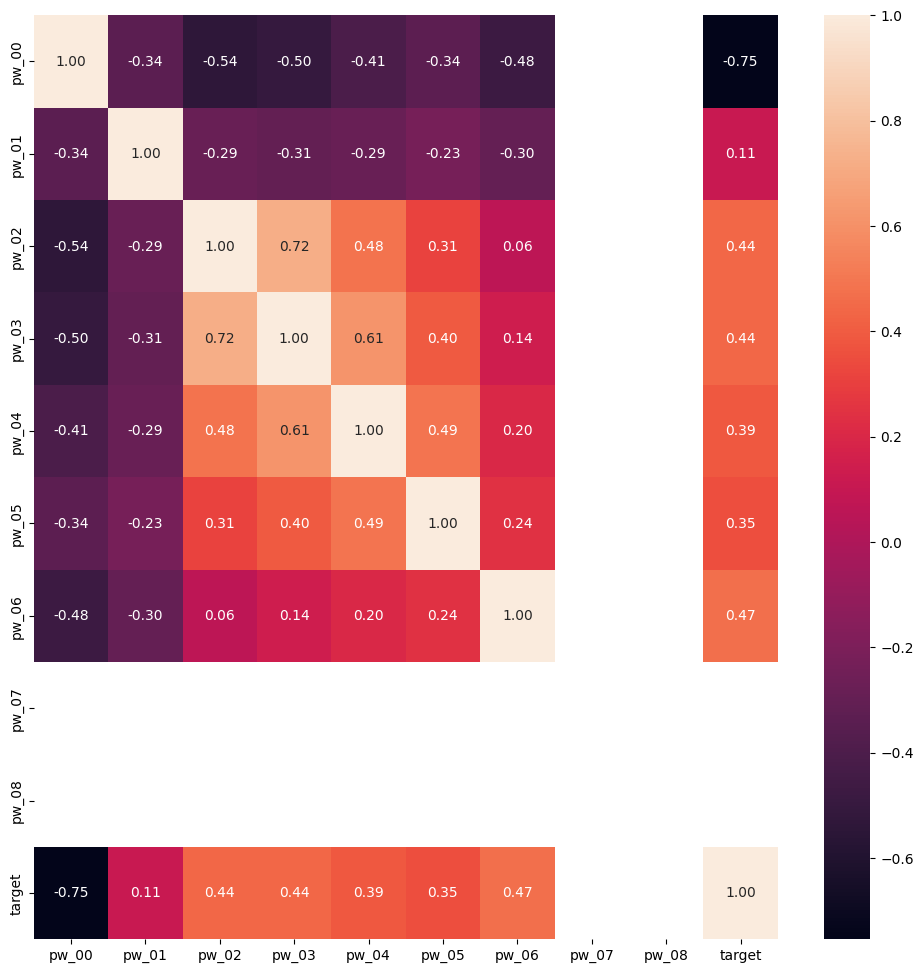

In [54]:
plot_correlation_heatmap(df, "pw", with_target=True)

In [55]:
data.drop(["pw_08", "pw_07"], axis=1, inplace=True)

In [168]:
dropped_cols = dropped_cols + ["pw_08", "pw_07"]

### Other columns

### All columns

In [56]:
data.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL'],
      dtype='object')

In [58]:
in_cols = [col for col in data.columns if col not in ["ward", "ADM4_PCODE"]]

In [61]:
col_prefix = ["psa", "stv", "car", "lln", "lan", "dw", "pg", "pw"]
for col in col_prefix:
    print("Min: ", sum_columns(data, col).value_counts().index.min(), "Max: ", sum_columns(data, col).value_counts().index.max(), "Column: ", col)

Min:  0.9999999528999999 Max:  1.0000000497 Column:  psa
Min:  1.0 Max:  1.0 Column:  stv
Min:  1.0 Max:  1.0000000001 Column:  car
Min:  1.0 Max:  1.0 Column:  lln
Min:  0.9999999155000001 Max:  1.0000001177 Column:  lan
Min:  0.9999999507 Max:  1.0000000286000001 Column:  dw
Min:  0.9999999502 Max:  1.0000000713 Column:  pg
Min:  0.9999999636000001 Max:  1.0000000499 Column:  pw


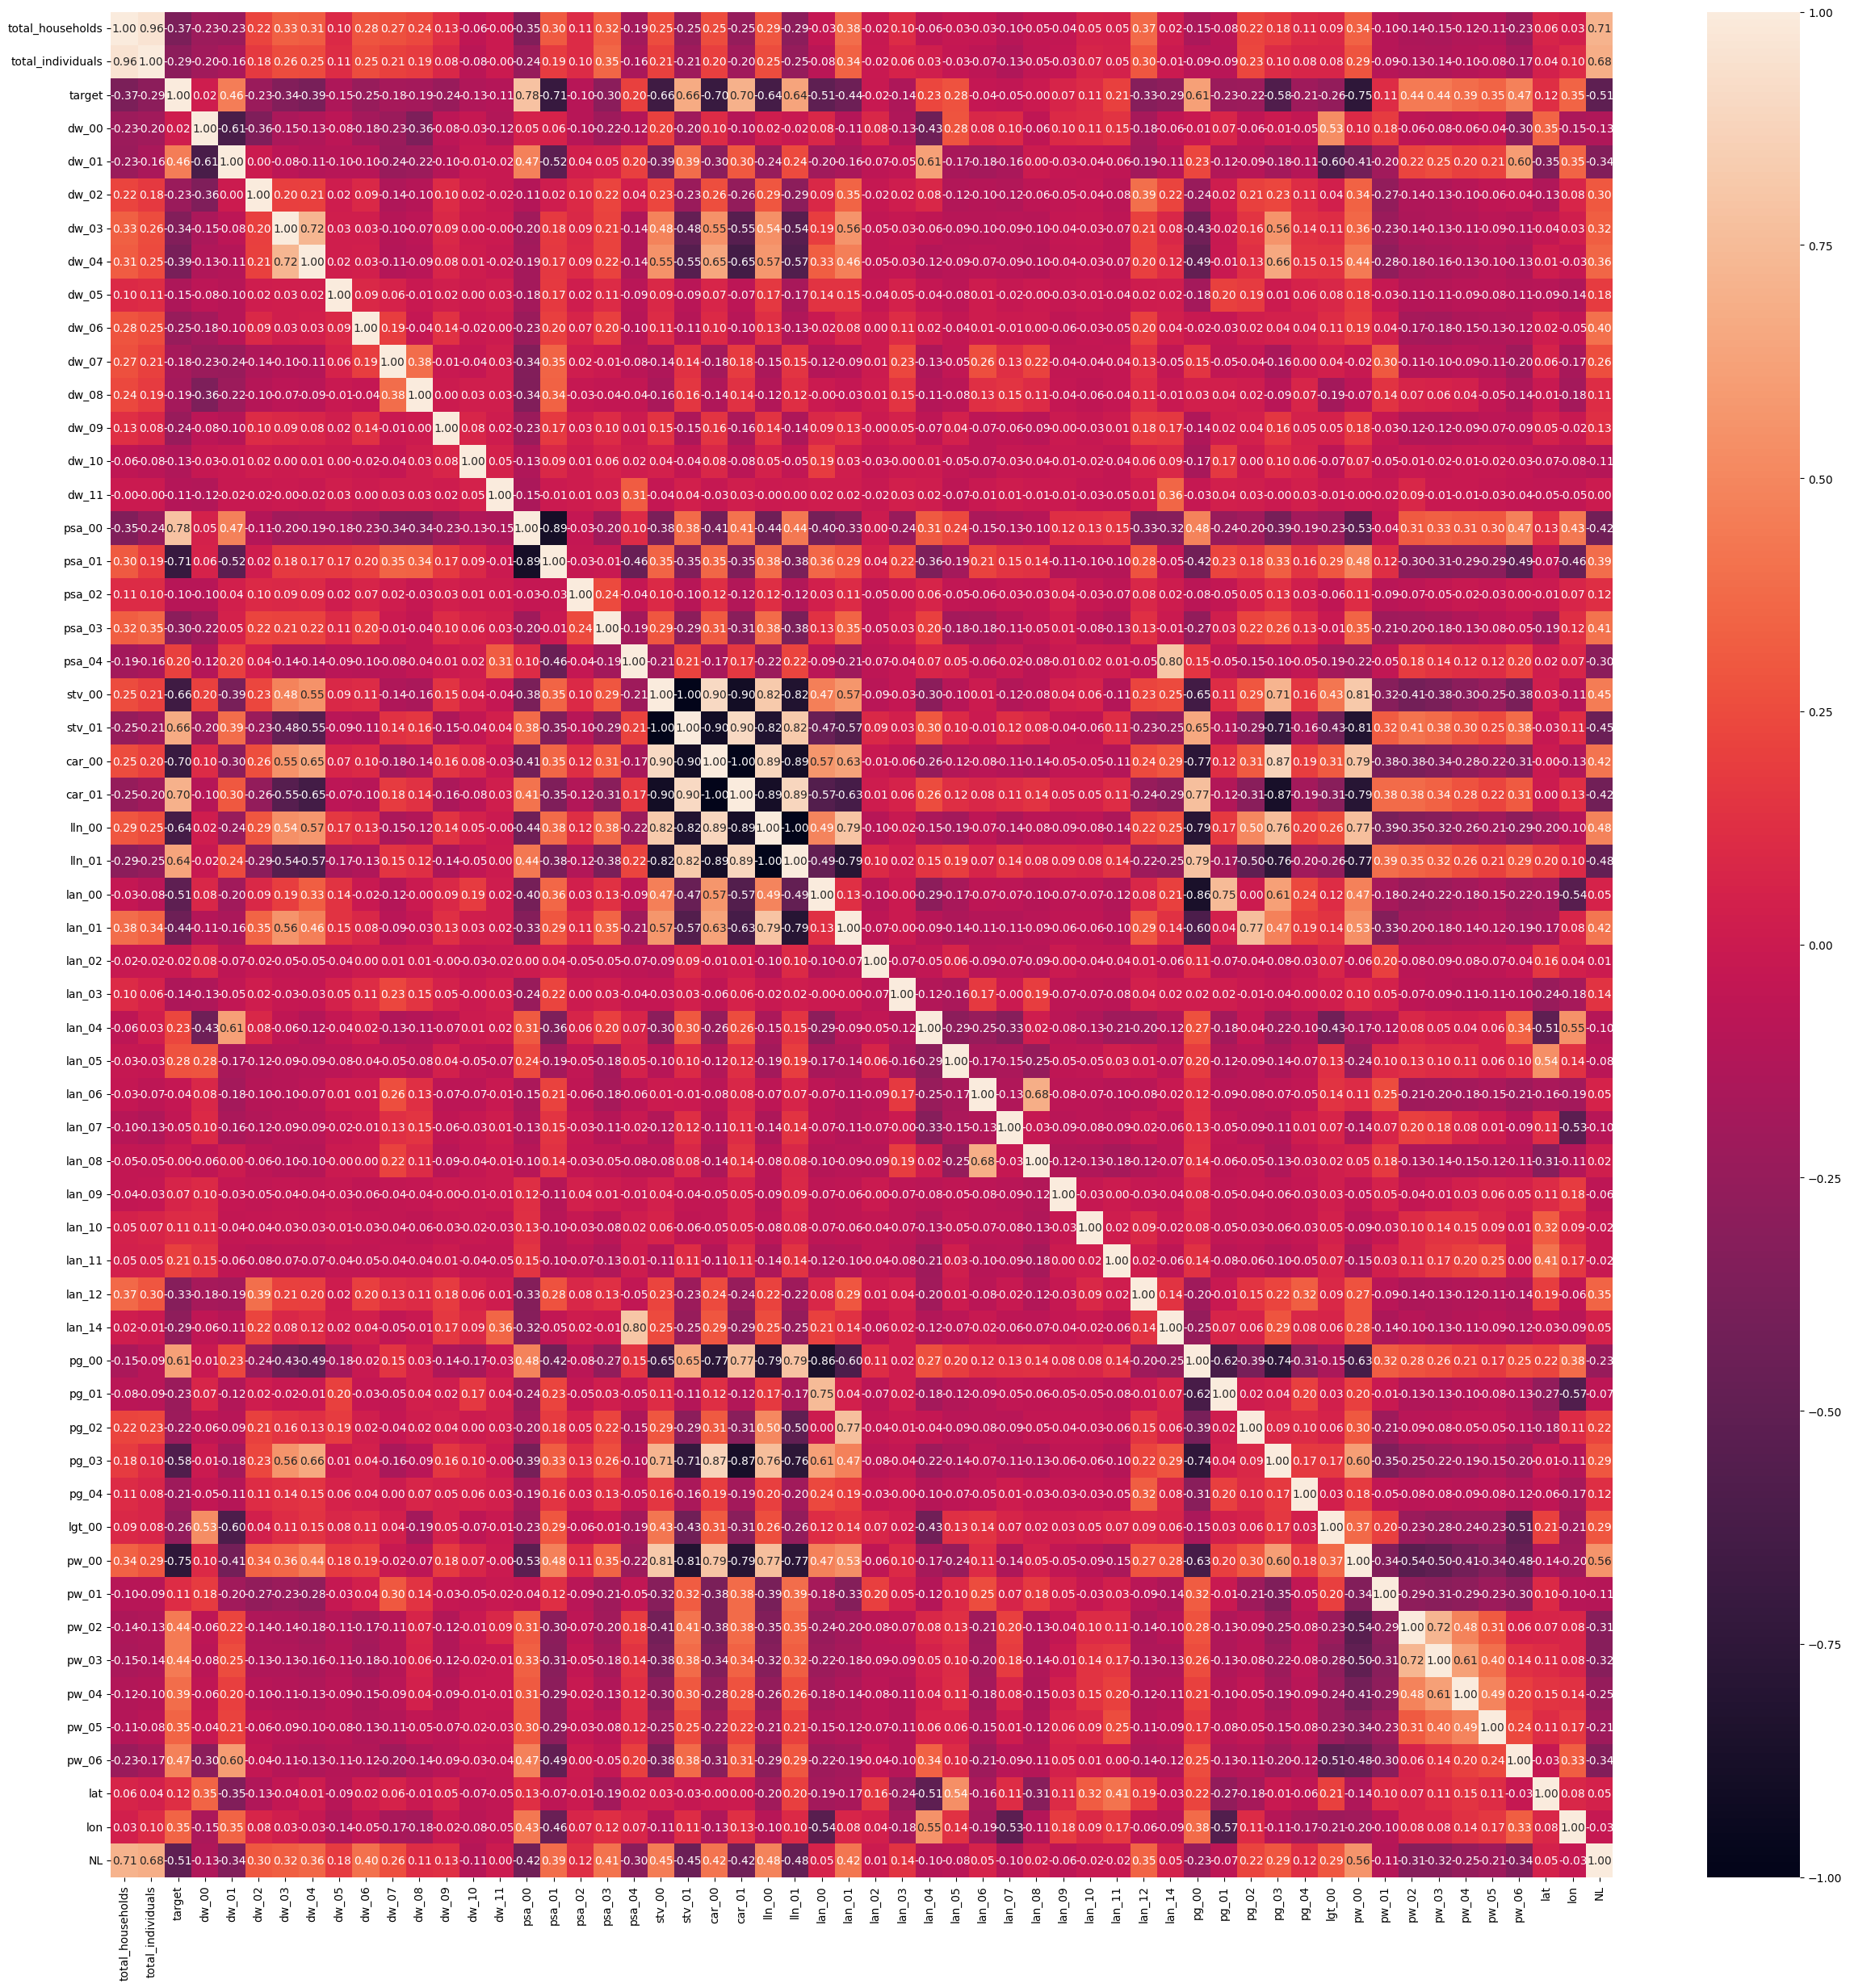

In [63]:
## Correlation matrix
corr = data[in_cols].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Feature Engineering

In [64]:
nn_cols = ["dw_00", "psa_00", "lan_00", "pg_00", "pw_00", "stv_00", "car_00", "lln_00"]
data.drop(nn_cols, axis=1, inplace=True)

We drop the columns `dw_00`, `psa_00`, `lan_00`, `pg_00`, `pw_00`, `stv_00`, `car_00`, `lln_00` because if we sum all of columns in each group, it's equal to 1. This means that we can drop one column from each group.

In [169]:
dropped_cols = dropped_cols + nn_cols

In [65]:
data.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_01',
       'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08', 'dw_09',
       'dw_10', 'dw_11', 'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_01',
       'car_01', 'lln_01', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12',
       'lan_14', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL'],
      dtype='object')

In [83]:
## Normalize total_individuals and total_households with min-max scaler
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data["norm_total_individuals"] = scaler.fit_transform(data["total_individuals"].values.reshape(-1, 1))
# data["norm_total_households"] = scaler.fit_transform(data["total_households"].values.reshape(-1, 1))
#
# ## Create a new feature percentage of individuals to households
# data["phi"] = data["norm_total_individuals"] / data["norm_total_households"]

data["phi"] = data["total_individuals"] / data["total_households"]

In [87]:
unused_cols = ["ward", "ADM4_PCODE", "total_individuals", "total_households", "norm_total_individuals", "norm_total_households"]
features = [col for col in data.columns if col not in unused_cols]
features_df = data[features].copy()

In [170]:
dropped_cols = dropped_cols + ["ward", "ADM4_PCODE", "total_individuals", "total_households"]

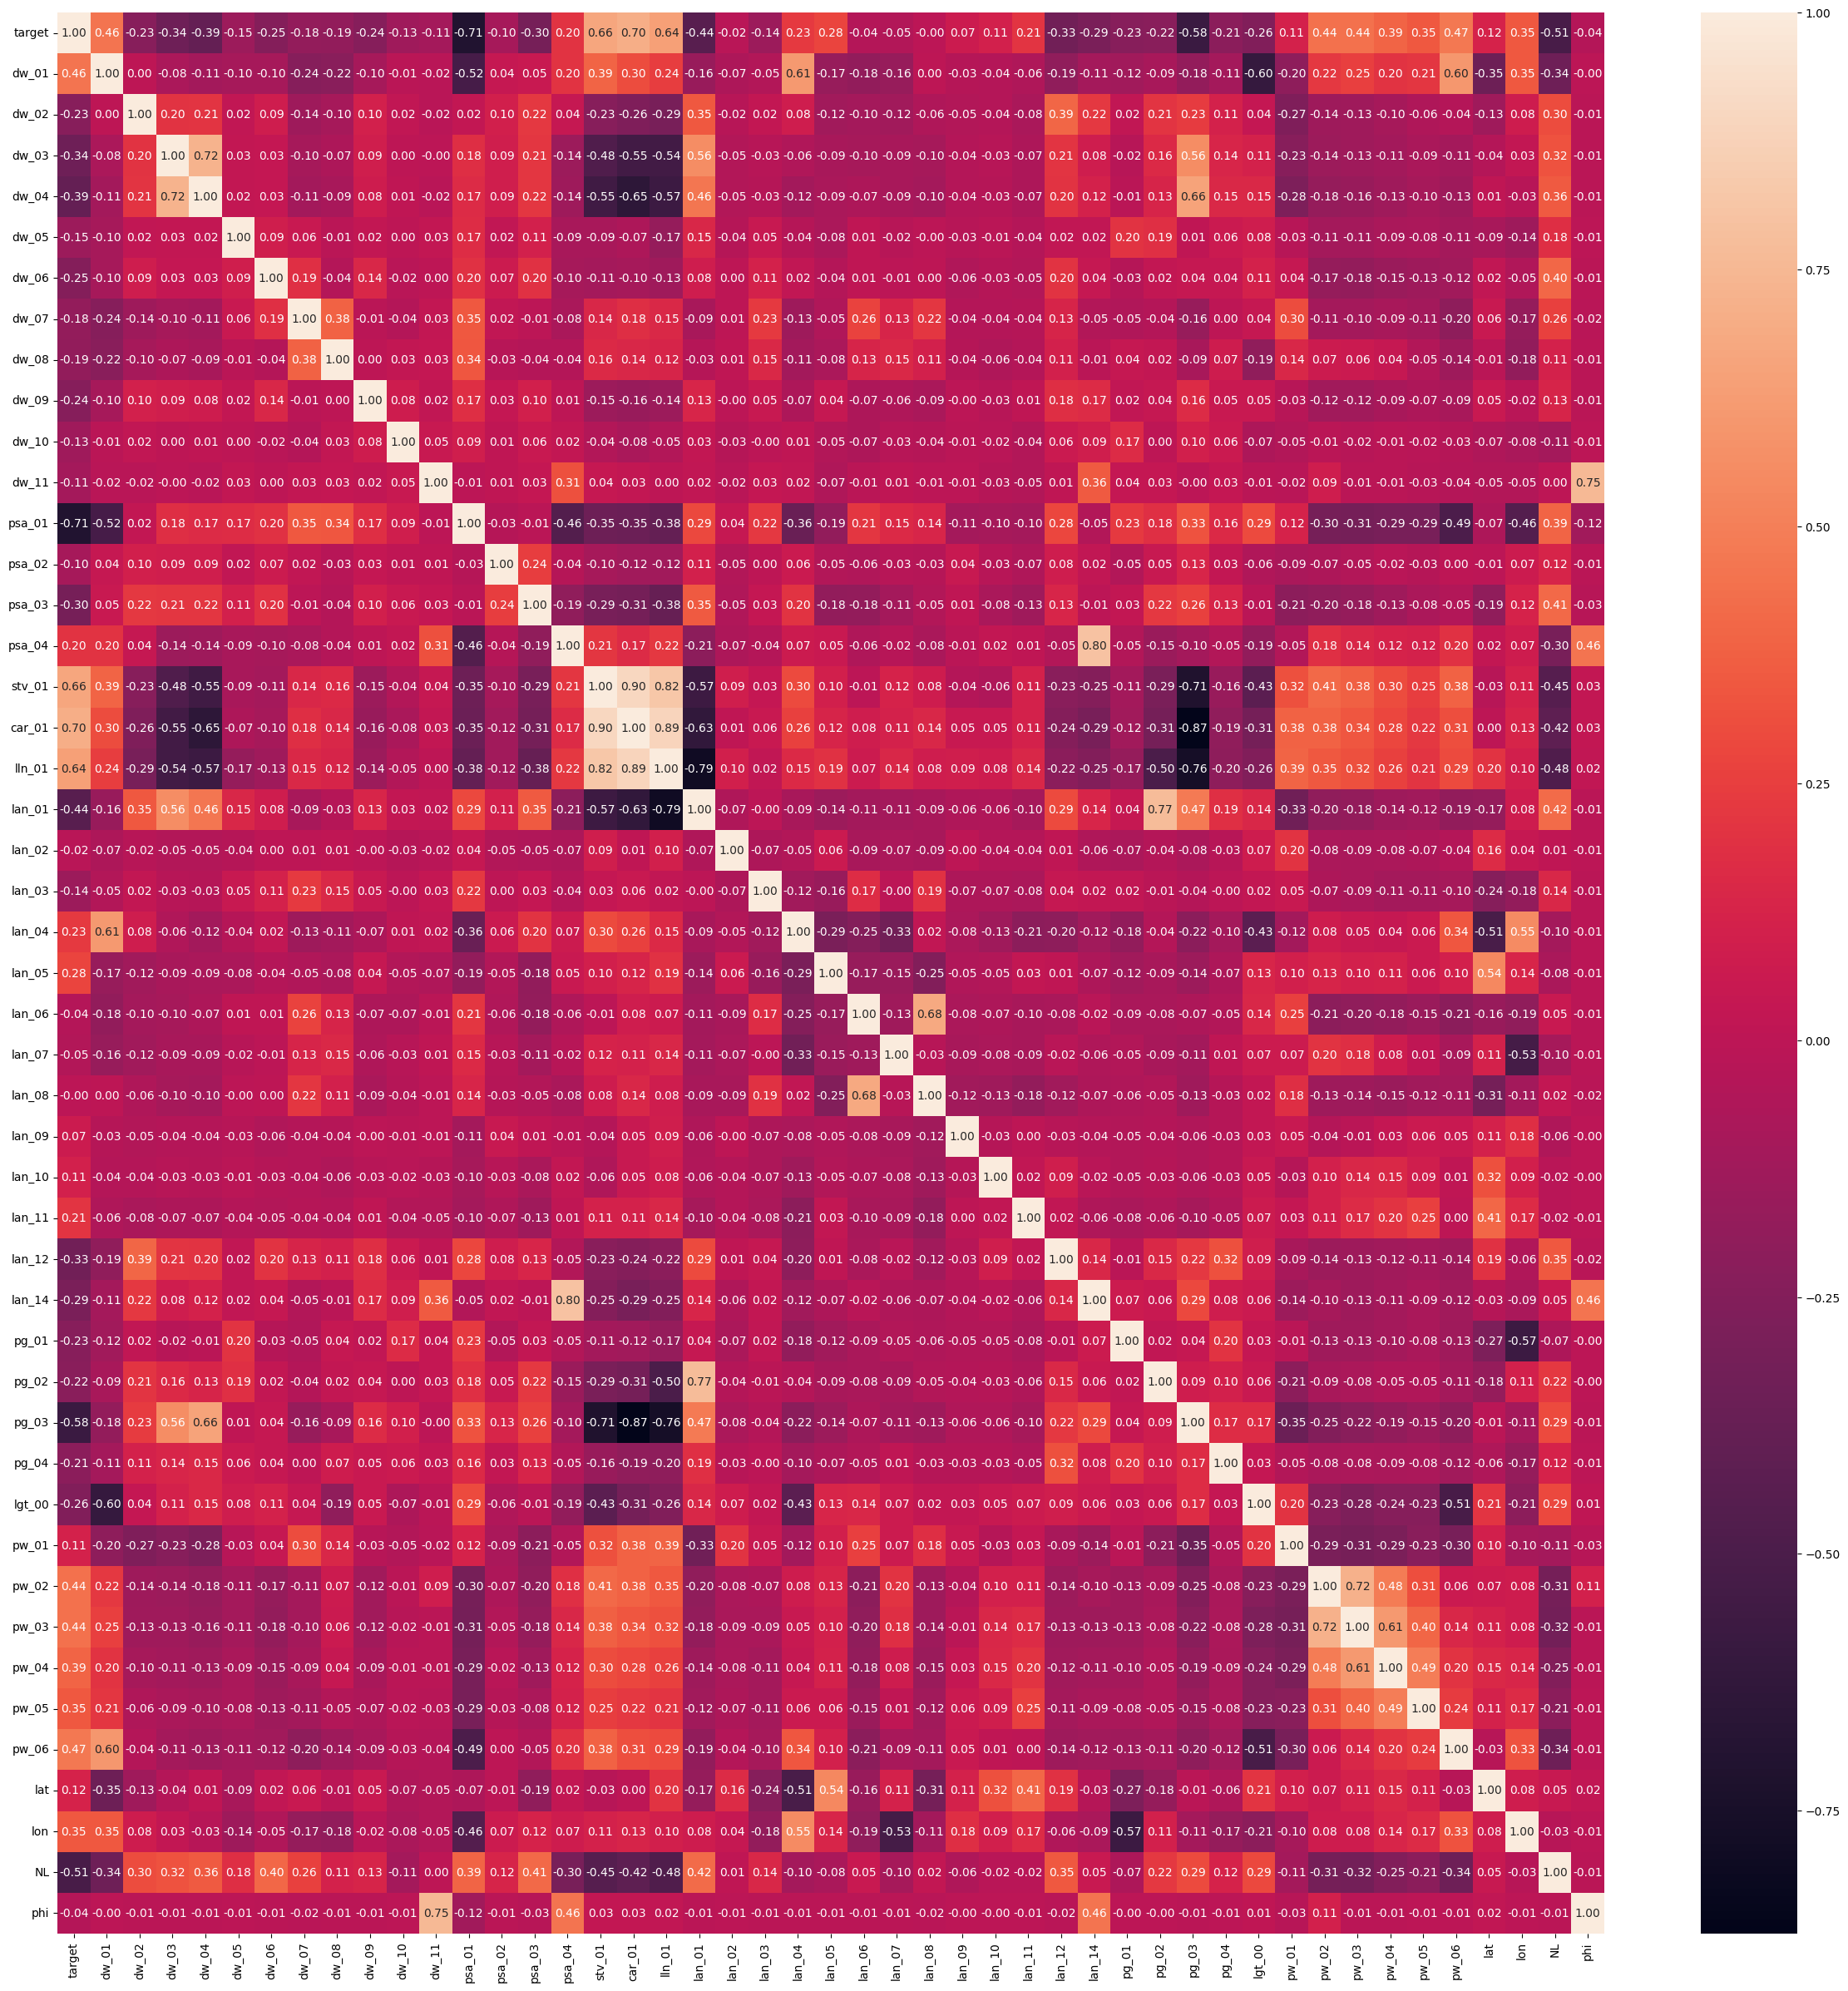

In [68]:
corr = features_df.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [74]:
features_df.columns

Index(['target', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_01', 'car_01', 'lln_01', 'lan_01', 'lan_02', 'lan_03',
       'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10',
       'lan_11', 'lan_12', 'lan_14', 'pg_01', 'pg_02', 'pg_03', 'pg_04',
       'lgt_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat',
       'lon', 'NL', 'phi'],
      dtype='object')

In [85]:
train_df = features_df.copy()
train_df.drop(["target"], axis=1, inplace=True)

In [86]:
train_df.describe()

dw_01        dw_02        dw_03        dw_04        dw_05  \
count  2822.000000  2822.000000  2822.000000  2822.000000  2822.000000   
mean      0.092616     0.032043     0.006057     0.008665     0.006289   
std       0.182852     0.080253     0.019374     0.030697     0.024606   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.002895     0.002407     0.000000     0.000000     0.000000   
50%       0.010425     0.005762     0.000807     0.000607     0.000865   
75%       0.068209     0.027913     0.002538     0.002225     0.003027   
max       0.931490     0.951806     0.264239     0.392085     0.435912   

             dw_06        dw_07        dw_08        dw_09        dw_10  ...  \
count  2822.000000  2822.000000  2822.000000  2822.000000  2822.000000  ...   
mean      0.022375     0.039296     0.064586     0.006864     0.001112  ...   
std       0.037127     0.057889     0.109802     0.016819     0.003041  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.002716     0.004716     0.002888     0.000233     0.000000  ...   
50%       0.008639     0.016295     0.014991     0.001755     0.000391  ...   
75%       0.025218     0.048730     0.074748     0.006507     0.001043  ...   
max       0.412936     0.455815     0.798479     0.282843     0.068752  ...   

             pw_01        pw_02        pw_03        pw_04        pw_05  \
count  2822.000000  2822.000000  2822.000000  2822.000000  2822.000000   
mean      0.329684     0.127555     0.041589     0.019655     0.011008   
std       0.236642     0.156400     0.057331     0.032926     0.023672   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.111282     0.008673     0.002099     0.000715     0.000159   
50%       0.302130     0.069065     0.016496     0.005164     0.001459   
75%       0.508771     0.183384     0.058626     0.025055     0.009432   
max       0.937595     1.000000     0.327393     0.306787     0.228261   

             pw_06          lat          lon           NL          phi  
count  2822.000000  2822.000000  2822.000000  2822.000000  2822.000000  
mean      0.110818   -26.880740    28.666515    17.437560     5.163249  
std       0.185401     2.021279     2.373809    18.958621    72.727066  
min       0.000000   -32.490089    16.760022     0.000000     1.254742  
25%       0.005217   -28.569019    27.707932     3.033397     3.246975  
50%       0.025165   -26.549866    28.959679     9.205572     3.706505  
75%       0.116638   -25.572130    30.441505    26.890531     4.197986  
max       0.961523   -22.331267    32.858249    63.000000  3867.000000  

[8 rows x 46 columns]

In [88]:
train_df.columns

Index(['dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_01', 'psa_02', 'psa_03', 'psa_04',
       'stv_01', 'car_01', 'lln_01', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
       'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
       'lan_12', 'lan_14', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat', 'lon',
       'NL', 'phi'],
      dtype='object')

In [89]:
## Normalize some columns with min-max scaler
from sklearn.preprocessing import MinMaxScaler
norm_cols = ["phi", "NL"]

scaler = MinMaxScaler()
train_df[norm_cols] = scaler.fit_transform(train_df[norm_cols])

In [96]:
## Transform lon and lat to a new feature
import h3.api.numpy_int as h3

def h3_transform(row):
    return h3.latlng_to_cell(row["lat"], row["lon"], 2)

train_df["h3"] = train_df.apply(h3_transform, axis=1)
train_df["h3"].nunique()

18

In [95]:
train_df["h3"].head()

0    597798802664980479
1    597798553556877311
2    597798476247465983
3    597798476247465983
4    597798467657531391
Name: h3, dtype: int64

In [110]:
import folium
resolution = 8
def h3_transform(row):
    return h3.latlng_to_cell(row["lat"], row["lon"], resolution)

train_df["h3"] = train_df.apply(h3_transform, axis=1)

h3_indices = train_df["h3"]
center_lat = train_df["lat"].mean()
center_lon = train_df["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Create a Folium map
for h3_idx in h3_indices:
    hex_boundary = h3.cell_to_boundary(h3_idx)
    folium.Polygon(
        locations=hex_boundary,
        color="blue",
        fill=True,
        fill_color="lightblue",
        fill_opacity=0.4
    ).add_to(m)

# Show the map
m

They are too many hexagons. Use a clustering algorithm is not maybe the best idea.

In [111]:
def latlon_to_xyz(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# Example: Normalize Cartesian coordinates between 0 and 1
def normalize_xyz(x, y, z):
    # Normalizing each coordinate to the [0, 1] range
    return (x + 1) / 2, (y + 1) / 2, (z + 1) / 2

# Transform the lat/lon coordinates to Cartesian coordinates
train_df["x"], train_df["y"], train_df["z"] = zip(*train_df.apply(lambda x: latlon_to_xyz(x["lat"], x["lon"]), axis=1))
train_df["x"], train_df["y"], train_df["z"] = zip(*train_df.apply(lambda x: normalize_xyz(x["x"], x["y"], x["z"]), axis=1))

In [112]:
train_df.drop(["lat", "lon"], axis=1, inplace=True)

## Modeling

In [161]:
## Split the data
from sklearn.model_selection import train_test_split
X = train_df.copy()
y = data["target"]
X.drop(["h3"], axis=1, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

baseline_data = features_df.copy()
X_b = baseline_data.copy()
y_b = baseline_data["target"]
X_b.drop(["target"], axis=1, inplace=True)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_b, y_b, test_size=0.2, shuffle=False)

In [121]:
X.columns, X_b.columns

(Index(['dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
        'dw_09', 'dw_10', 'dw_11', 'psa_01', 'psa_02', 'psa_03', 'psa_04',
        'stv_01', 'car_01', 'lln_01', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
        'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
        'lan_12', 'lan_14', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
        'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'NL', 'phi', 'x',
        'y', 'z'],
       dtype='object'),
 Index(['dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
        'dw_09', 'dw_10', 'dw_11', 'psa_01', 'psa_02', 'psa_03', 'psa_04',
        'stv_01', 'car_01', 'lln_01', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
        'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
        'lan_12', 'lan_14', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
        'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat', 'lon',
        'NL', 'phi'],
       dt

### Linear Regression

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
lr_rmse = np.sqrt(mean_squared_error(y_val, lr_preds))
lr_rmse

np.float64(3.7126053237238033)

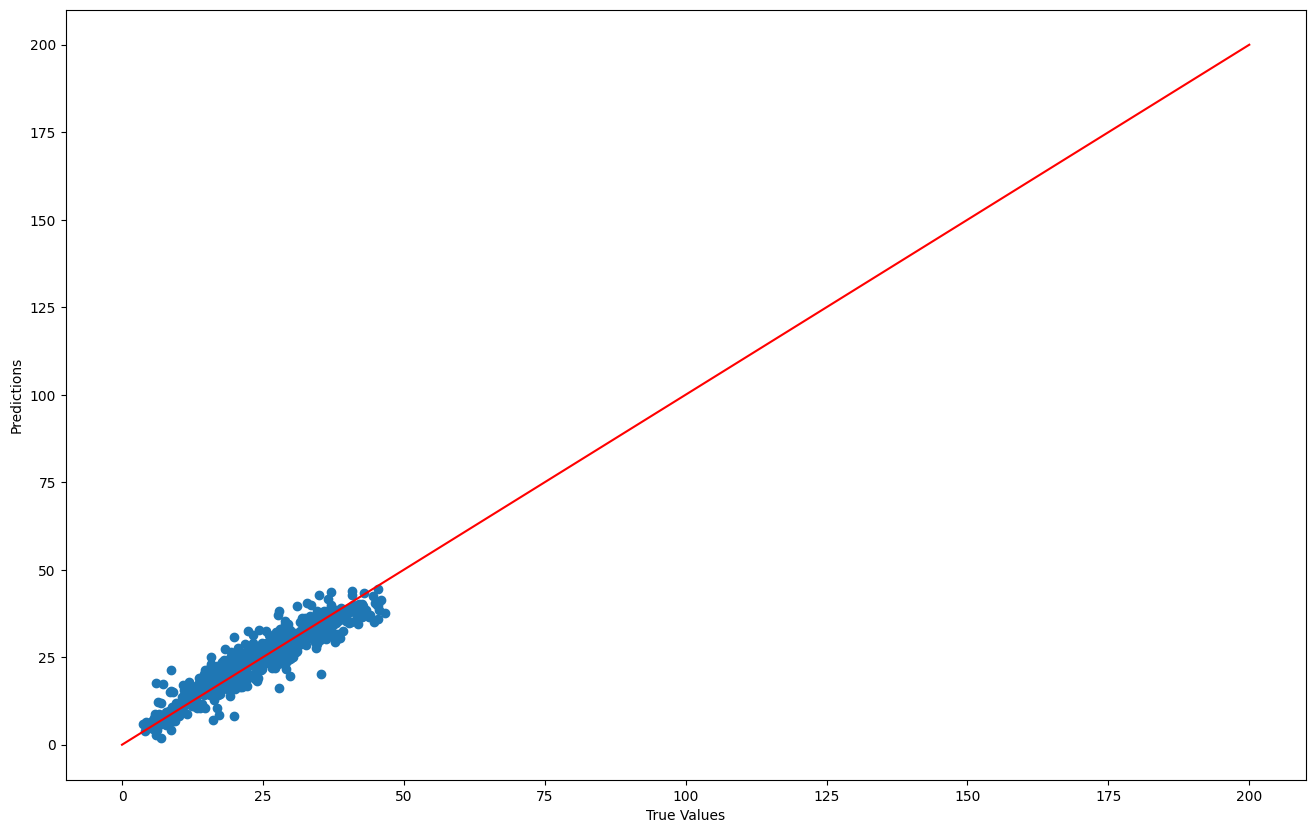

In [124]:
## Plot the residuals
plt.scatter(y_val, lr_preds)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.plot([0, 200], [0, 200], color="red")
plt.show()

In [125]:
## Compute R2 score
from sklearn.metrics import r2_score
r2_score(y_val, lr_preds)

0.8602865401657978

In [126]:
## Baseline
lr_b = LinearRegression()
lr_b.fit(X_train_b, y_train_b)
lr_preds_b = lr_b.predict(X_val_b)
lr_rmse_b = np.sqrt(mean_squared_error(y_val_b, lr_preds_b))
lr_r2_b = r2_score(y_val_b, lr_preds_b)
lr_rmse_b, lr_r2_b

(np.float64(3.732602357124528), 0.858777422614402)

### Random Forest

In [127]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
rf_r2_b = r2_score(y_val, rf_preds)
rf_rmse, rf_r2_b

(np.float64(3.427679755115209), 0.880908391731579)

In [128]:
## Baseline
rf_b = RandomForestRegressor(n_estimators=100, random_state=42)
rf_b.fit(X_train_b, y_train_b)
rf_preds_b = rf_b.predict(X_val_b)
rf_rmse_b = np.sqrt(mean_squared_error(y_val_b, rf_preds_b))
rf_r2_b = r2_score(y_val_b, rf_preds_b)
rf_rmse_b, rf_r2_b

(np.float64(3.427152299137855), 0.8809450408657153)

### XGBoost

In [129]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_preds))
xgb_r2 = r2_score(y_val, xgb_preds)
xgb_rmse, xgb_r2

(np.float64(3.5117823077770334), 0.8749925620117438)

In [130]:
## Baseline
xgb_b = XGBRegressor(n_estimators=100, random_state=42)
xgb_b.fit(X_train_b, y_train_b)
xgb_preds_b = xgb_b.predict(X_val_b)
xgb_rmse_b = np.sqrt(mean_squared_error(y_val_b, xgb_preds_b))
xgb_r2_b = r2_score(y_val_b, xgb_preds_b)
xgb_rmse_b, xgb_r2_b

(np.float64(3.4788191948194673), 0.8773282963531677)

### Cross-validation

In [137]:
### Cross-validation
fe_models = [xgb, rf, lr]

for model in fe_models:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")
    print("\n\n")

Model: XGBRegressor RMSE: 4.251962675893964 R2: 0.7986086119923921
RMSE list: [np.float64(4.041960483986618), np.float64(3.6864869033942798), np.float64(4.543544273522393), np.float64(4.8554378973163175), np.float64(4.132383821250206)]
R2 list: [0.7493336535953845, 0.8835071990313138, 0.7942271655635714, 0.7867873213233016, 0.7791877204483888]



Model: RandomForestRegressor RMSE: 4.226286253261867 R2: 0.7986497578447822
RMSE list: [np.float64(4.156474940995718), np.float64(3.509322001750918), np.float64(4.578885503081055), np.float64(4.671194433043781), np.float64(4.215554387437858)]
R2 list: [0.7349289872645745, 0.8944349554478841, 0.7910135738774507, 0.8026613702425412, 0.7702099023914606]



Model: LinearRegression RMSE: 51.95712682416797 R2: -106.03966116731885
RMSE list: [np.float64(3.800957614160445), np.float64(3.929368465474286), np.float64(4.694444875169927), np.float64(243.08050107961435), np.float64(4.280362086420847)]
R2 list: [0.7783345751263901, 0.8676514438285192, 0.780

In [139]:
bl_models = [xgb_b, rf_b, lr_b]
for model in bl_models:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")
    print("\n\n")

Model: XGBRegressor RMSE: 4.251962675893964 R2: 0.7986086119923921
RMSE list: [np.float64(4.041960483986618), np.float64(3.6864869033942798), np.float64(4.543544273522393), np.float64(4.8554378973163175), np.float64(4.132383821250206)]
R2 list: [0.7493336535953845, 0.8835071990313138, 0.7942271655635714, 0.7867873213233016, 0.7791877204483888]



Model: RandomForestRegressor RMSE: 4.226286253261867 R2: 0.7986497578447822
RMSE list: [np.float64(4.156474940995718), np.float64(3.509322001750918), np.float64(4.578885503081055), np.float64(4.671194433043781), np.float64(4.215554387437858)]
R2 list: [0.7349289872645745, 0.8944349554478841, 0.7910135738774507, 0.8026613702425412, 0.7702099023914606]



Model: LinearRegression RMSE: 51.95712682416797 R2: -106.03966116731885
RMSE list: [np.float64(3.800957614160445), np.float64(3.929368465474286), np.float64(4.694444875169927), np.float64(243.08050107961435), np.float64(4.280362086420847)]
R2 list: [0.7783345751263901, 0.8676514438285192, 0.780

In [140]:
## LightGBM
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators=100, random_state=42)

for model in [lgb]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")
    print("\n\n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 47
[LightGBM] [Info] Start training from score 25.646810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 47
[LightGBM] [Info] Start training from score 24.692935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2258, number of used features: 47
[LightGBM] [Info] Start t

In [148]:
## ElasticNet
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=0.01, l1_ratio=0.95)

for model in [en]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")


Model: ElasticNet RMSE: 4.642300568651481 R2: 0.7552699878165622
RMSE list: [np.float64(4.908412682913506), np.float64(3.9664299938665564), np.float64(5.131306961619375), np.float64(4.906335831058763), np.float64(4.299017373799207)]
R2 list: [0.630347163092912, 0.8651430652880655, 0.7375452106670009, 0.7822938175804218, 0.7610206824544107]


In [149]:
## SVR
from sklearn.svm import SVR
svr = SVR()

for model in [svr]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")

Model: SVR RMSE: 4.973112680563321 R2: 0.7179299711868523
RMSE list: [np.float64(5.052910396894806), np.float64(3.842152946024078), np.float64(5.716089766127479), np.float64(5.478253351082695), np.float64(4.776156942687547)]
R2 list: [0.6082625443256132, 0.8734614088336683, 0.6743158734980066, 0.7285808756159149, 0.7050291536610587]


In [150]:
## GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()

for model in [gb]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")

Model: GradientBoostingRegressor RMSE: 4.122861737515959 R2: 0.811083607939743
RMSE list: [np.float64(3.8583632942070936), np.float64(3.5928203922475777), np.float64(4.446233390667785), np.float64(4.69752008901863), np.float64(4.019371521438705)]
R2 list: [0.7715884089274393, 0.8893517088756171, 0.8029470127654905, 0.8004308024546519, 0.7911001066755159]


In [151]:
## AdaBoost
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()

for model in [ada]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")

Model: AdaBoostRegressor RMSE: 4.801445251252366 R2: 0.7406541064776361
RMSE list: [np.float64(4.8730205941875075), np.float64(4.222343825294708), np.float64(5.345679371880622), np.float64(5.036400770126718), np.float64(4.529781694772277)]
R2 list: [0.6356587047897475, 0.8471797566628191, 0.7151578044496512, 0.7705982205802797, 0.7346760459056834]


In [152]:
## GLM
from sklearn.linear_model import TweedieRegressor
glm = TweedieRegressor()

for model in [glm]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")

Model: TweedieRegressor RMSE: 9.658188054895021 R2: -0.020750410590584488
RMSE list: [np.float64(8.78346440990792), np.float64(9.584804595522858), np.float64(11.214596276194346), np.float64(10.145584221724564), np.float64(8.562490771125422)]
R2 list: [-0.18370531078861374, 0.21251874697801798, -0.25361967216857373, 0.06908433205120279, 0.05196985097504425]


In [154]:
for model in [lgb]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y, n_splits=10)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")
    print("\n\n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2539, number of used features: 47
[LightGBM] [Info] Start training from score 24.636763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2539, number of used features: 47
[LightGBM] [Info] Start training from score 25.392813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2540, number of used features: 47
[LightGBM] [Info] Start t

In [155]:
for model in [gb]:
    rmse, r2, rmse_list, r2_list = cross_val(model, X, y, n_splits=10)
    print(f"Model: {model.__class__.__name__} RMSE: {rmse} R2: {r2}")
    print(f"RMSE list: {rmse_list}")
    print(f"R2 list: {r2_list}")
    print("\n\n")

Model: GradientBoostingRegressor RMSE: 4.01957149996902 R2: 0.7833076566557662
RMSE list: [np.float64(4.215231703521821), np.float64(3.372025433406734), np.float64(2.9419881055658044), np.float64(4.022469011027599), np.float64(4.810041878643267), np.float64(4.250365060389754), np.float64(5.05286325092139), np.float64(4.133003954697506), np.float64(3.8143369020102798), np.float64(3.5833896995060424)]
R2 list: [0.7197300826129316, 0.7399241442874411, 0.9001982899923207, 0.7897978621654198, 0.7171208201048962, 0.8476800272157458, 0.7124090266642721, 0.7774867816149431, 0.8213177435980922, 0.8074117883015982]





### Hyperparameter tuning

#### GradientBoosting

In [163]:
## Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.1),
    "subsample": uniform(0.5, 0.5),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["auto", "sqrt", "log2"]
}

gb = GradientBoostingRegressor()
rs = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=100, cv=10, n_jobs=-1, random_state=None, verbose=0)
rs.fit(X, y)
best_gb_params = rs.best_params_
best_gb_params

C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
320 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Public\Documents\Konrad\zindi\women_poverty\venv\Lib\site-packages

{'learning_rate': np.float64(0.05315047447023675),
 'max_depth': 6,
 'max_features': 'log2',
 'min_samples_leaf': 11,
 'min_samples_split': 4,
 'n_estimators': 180,
 'subsample': np.float64(0.994771943003804)}

#### LightGBM

In [164]:
param_dist = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.1),
    "subsample": uniform(0.5, 0.5),
    "min_child_samples": randint(2, 20),
    "num_leaves": randint(2, 20),
    "max_features": ["auto", "sqrt", "log2"]
}

lgb = LGBMRegressor()
rs = RandomizedSearchCV(lgb, param_distributions=param_dist, n_iter=100, cv=10, n_jobs=-1, random_state=None, verbose=0)
rs.fit(X, y)
best_lgb_params = rs.best_params_
best_lgb_params

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2822, number of used features: 47
[LightGBM] [Info] Start training from score 24.507554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


{'learning_rate': np.float64(0.09771560651398557),
 'max_depth': 6,
 'max_features': 'log2',
 'min_child_samples': 12,
 'n_estimators': 177,
 'num_leaves': 9,
 'subsample': np.float64(0.7372918456790871)}

#### Evaluate the best models

In [165]:
best_lgb = LGBMRegressor(**best_lgb_params)
best_gb = GradientBoostingRegressor(**best_gb_params)

best_lgb.fit(X_train, y_train)
best_lgb_preds = best_lgb.predict(X_val)
best_lgb_rmse = np.sqrt(mean_squared_error(y_val, best_lgb_preds))
best_lgb_r2 = r2_score(y_val, best_lgb_preds)

best_gb.fit(X_train, y_train)
best_gb_preds = best_gb.predict(X_val)
best_gb_rmse = np.sqrt(mean_squared_error(y_val, best_gb_preds))
best_gb_r2 = r2_score(y_val, best_gb_preds)

best_lgb_rmse, best_lgb_r2, best_gb_rmse, best_gb_r2

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 2257, number of used features: 47
[LightGBM] [Info] Start training from score 25.005118
[LightGBM] [Warning] Unknown parameter: max_features


(np.float64(3.9876937454573413),
 0.7941645029689405,
 np.float64(4.050487049721149),
 0.7876309745410077)

## Submission

In [180]:
## Function that group all preprocessing steps
def preprocess_data(df):
    ## Drop columns
    test_df = df.copy()

    ## Create a new feature phi
    test_df["phi"] = test_df["total_individuals"] / test_df["total_households"]

    ## Drop columns
    test_df.drop(dropped_cols, axis=1, inplace=True)

    ## Normalize some columns
    test_df[norm_cols] = scaler.transform(test_df[norm_cols])

    ## Transform lat and lon to xyz
    test_df["x"], test_df["y"], test_df["z"] = zip(*test_df.apply(lambda x: latlon_to_xyz(x["lat"], x["lon"]), axis=1))
    test_df["x"], test_df["y"], test_df["z"] = zip(*test_df.apply(lambda x: normalize_xyz(x["x"], x["y"], x["z"]), axis=1))

    features = X.columns

    return test_df[features].copy()

In [181]:
test_feature_df = preprocess_data(test_df)

In [182]:
test_feature_df.columns

Index(['dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_01', 'psa_02', 'psa_03', 'psa_04',
       'stv_01', 'car_01', 'lln_01', 'lan_01', 'lan_02', 'lan_03', 'lan_04',
       'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11',
       'lan_12', 'lan_14', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'NL', 'phi', 'x',
       'y', 'z'],
      dtype='object')

In [183]:
test_df['target'] = best_lgb.predict(test_feature_df)

[LightGBM] [Warning] Unknown parameter: max_features


In [184]:
test_df[['ward', 'target']].to_csv('starter_nb_submission.csv', index=False)